In [44]:
import pandas as pd
import numpy as np
from pprint import pprint
import itertools
import operator
from tqdm import tqdm

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import seaborn as sns
mallet_path = 'mallet-2.0.8/bin/mallet'

# for paralellization
from joblib import Parallel, delayed
import random


%matplotlib inline

In [2]:
lemmatized_df = pd.read_csv("/Users/PocketmathUser/Downloads/lemmatized_data.csv")
print(lemmatized_df.shape)
# remove na nan documents
lemmatized_df = lemmatized_df[lemmatized_df.lemmatized_desc ==
                              lemmatized_df.lemmatized_desc]
print(lemmatized_df.shape)

(79766, 5)
(76242, 5)


In [3]:
def get_doc_len(doc):
    split = doc.split()
    return len(split)


lemmatized_df["len_docs"] = lemmatized_df.lemmatized_desc.apply(get_doc_len)
lemmatized_df = lemmatized_df[lemmatized_df.len_docs >= 10]
print(lemmatized_df.shape)

(71455, 6)


In [4]:
lemmatized_df.reset_index(inplace=True)
lemmatized_df.drop("index", axis=1,inplace=True)
lemmatized_df.head()

,lemmatized_desc,bundle_id,description,icon_url,primary_genre,len_docs
0,voice recorder audio recorder voice recorder r...,com.nosoft.voicerecording.voicerecorder,Voice Recorder - HD Audio Recorder App is the ...,https://lh3.googleusercontent.com/QfsL5VLwaeUh...,MUSIC_AND_AUDIO,144
1,photo photo animation heart lovely video photo...,com.loveeffect.videomaker,Love Photo Effects is the best app make an pho...,https://lh3.googleusercontent.com/RTDwTk6DBPH5...,VIDEO_PLAYERS,130
2,connect friend safe environment explore concep...,com.amod.pxd,Connect and play with your friends in a safe e...,https://lh3.googleusercontent.com/sMl0s_so1Cx9...,ENTERTAINMENT,93
3,blow house boom_boom boom bomb manipulate avoi...,com.maxmiller.mrbomb,Blow up the house!Boom!Boom!Boom! Relaxing gam...,https://lh3.googleusercontent.com/_4TdUsyOy5HJ...,GAME_CASUAL,12
4,euchre card game bacon trick card game popular...,com.euchre.classic.game,Euchre card game or bacon is a trick-taking ca...,https://lh3.googleusercontent.com/VOSc73wXYf8N...,GAME_CARD,104


In [5]:
# Create Dictionary
data_lemmatized = list(lemmatized_df["lemmatized_desc"].str.split())
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# View Gensim creates a unique id for each word in the document.
# The produced corpus shown below is a mapping of
# (word_id, word_frequency).
print(corpus[1:2])

[[(17, 3), (26, 1), (29, 1), (36, 1), (57, 1), (59, 1), (62, 1), (68, 1), (70, 1), (74, 1), (75, 1), (76, 1), (77, 5), (78, 7), (79, 2), (80, 1), (81, 1), (82, 1), (83, 2), (84, 1), (85, 1), (86, 5), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 2), (96, 7), (97, 2), (98, 1), (99, 1), (100, 1), (101, 1), (102, 6), (103, 1), (104, 4), (105, 1), (106, 1), (107, 19), (108, 1), (109, 1), (110, 1), (111, 1), (112, 3), (113, 1), (114, 1), (115, 1), (116, 2), (117, 3), (118, 1), (119, 19)]]


In [6]:
descriptions = lemmatized_df.description.values.tolist()
bundle_ids = lemmatized_df.bundle_id.values.tolist()
lemmatized_desc = lemmatized_df.lemmatized_desc.values.tolist()
icon_urls = lemmatized_df.icon_url.values.tolist()
primary_genres = lemmatized_df.primary_genre.values.tolist()


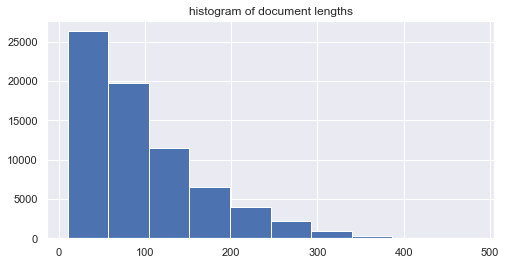

In [7]:
sns.set(rc={'figure.figsize': (8, 4)})
# fig, ax = plt.subplots()
title = lemmatized_df.len_docs.hist().set_title(r"histogram of document lengths")

In [8]:
print(data_lemmatized[1:2])
print(corpus[1:2])
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[1:2]]

[['photo', 'photo', 'animation', 'heart', 'lovely', 'video', 'photo', 'video', 'maker', 'photo', 'music', 'create', 'image', 'slide', 'photo', 'animation', 'animate', 'gif', 'heart', 'theme', 'music', 'slide', 'time', 'create', 'beautiful', 'heart', 'photo', 'song', 'share', 'friend', 'family', 'occasion', 'life', 'photo', 'maker', 'easily', 'create', 'photo', 'beautiful', 'attractive', 'live', 'animate', 'heart', 'shape', 'figurine', 'video', 'animate', 'heart', 'romantic', 'video', 'studio', 'easily', 'filmy', 'style', 'video', 'photo', 'video', 'maker', 'photo', 'video', 'maker', 'reach', 'video', 'theme', 'apply', 'photo', 'create', 'video', 'image', 'video', 'stunning', 'apply', 'animation', 'video', 'video', 'art', 'animation', 'large', 'number', 'amazing', 'photo', 'video', 'maker', 'photo', 'animation', 'multiple', 'photo', 'album', 'easily', 'arrange', 'photo', 'photo', 'animation', 'slide', 'rectangle_triangle', 'diamond', 'circle', 'animate', 'gif', 'theme', 'heart', 'animat

[[('easily', 3),
  ('friend', 1),
  ('high_quality', 1),
  ('live', 1),
  ('save', 1),
  ('share', 1),
  ('song', 1),
  ('tablet', 1),
  ('time', 1),
  ('accord', 1),
  ('album', 1),
  ('amazing', 1),
  ('animate', 5),
  ('animation', 7),
  ('apply', 2),
  ('arrange', 1),
  ('art', 1),
  ('attractive', 1),
  ('beautiful', 2),
  ('card', 1),
  ('circle', 1),
  ('create', 5),
  ('creation', 1),
  ('default', 1),
  ('desire', 1),
  ('diamond', 1),
  ('family', 1),
  ('figurine', 1),
  ('filmy', 1),
  ('gallery', 1),
  ('gif', 2),
  ('heart', 7),
  ('image', 2),
  ('instantly', 1),
  ('large', 1),
  ('life', 1),
  ('lovely', 1),
  ('maker', 6),
  ('multiple', 1),
  ('music', 4),
  ('number', 1),
  ('occasion', 1),
  ('photo', 19),
  ('reach', 1),
  ('rectangle_triangle', 1),
  ('romantic', 1),
  ('shape', 1),
  ('slide', 3),
  ('storage', 1),
  ('studio', 1),
  ('stunning', 1),
  ('style', 2),
  ('theme', 3),
  ('timer', 1),
  ('video', 19)]]

In [45]:
alpha_list = [22, 24]
topic_list = [18]
results = {}
models = {}
seed = random.randint(1, 100)

hyper_param_list = itertools.product(alpha_list, topic_list)
best_coherance = 0.0
best_alpha = 0
best_topics = 0


for hyper_param in hyper_param_list:
    ldamallet = gensim.models.wrappers.LdaMallet(
        mallet_path, corpus=corpus, num_topics=hyper_param[1], iterations=1000,
        alpha=hyper_param[0], id2word=id2word, workers=5, random_seed=seed)

    # compute coherance score
    coherence_model_ldamallet = CoherenceModel(
        model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()

    results[hyper_param] = coherence_ldamallet
    models[hyper_param] = ldamallet
    if coherence_ldamallet > best_coherance:
        best_alpha = hyper_param[0]
        best_topics = hyper_param[1]

        best_coherance = coherence_ldamallet
        print('Best coherence Score: ', best_coherance)

Best coherence Score:  0.646313669833478


In [46]:
print(results)
best_alpha,best_topics

{(22, 18): 0.646313669833478, (24, 18): 0.6289086003373823}


(22, 18)

In [48]:
best_model = gensim.models.wrappers.LdaMallet(
        mallet_path, corpus=corpus, num_topics=best_topics, iterations=1000,
        alpha=best_alpha, id2word=id2word, workers=5, prefix="saved_model/")


In [49]:
# Show Topics
pprint(best_model.show_topics(formatted=False))

[(6,
  [('game', 0.09939363738097744),
   ('puzzle', 0.05656377332391105),
   ('fun', 0.02832699333924732),
   ('match', 0.02403971105951289),
   ('block', 0.021939028659923577),
   ('challenge', 0.019282030573735457),
   ('bubble', 0.013063752918509417),
   ('time', 0.012748006177466851),
   ('brain', 0.012668532507952737),
   ('ball', 0.012170211120729095)]),
 (11,
  [('color', 0.06892840655808276),
   ('theme', 0.0322749659436236),
   ('number', 0.024928417886607136),
   ('beautiful', 0.0231753287396167),
   ('design', 0.02250694580150726),
   ('art', 0.017247678360535954),
   ('picture', 0.016072343956657065),
   ('background', 0.013934084980925597),
   ('image', 0.012231974193621474),
   ('enjoy', 0.012144178129717268)]),
 (17,
  [('word', 0.06917084371462444),
   ('language', 0.03431111491721283),
   ('learn', 0.02582767101365112),
   ('text', 0.0244280365778269),
   ('search', 0.02237006548576414),
   ('read', 0.018553853811796),
   ('easy', 0.01399902052351145),
   ('dictionary

In [50]:
generate_viz = False

In [51]:
pylda_viz = None
if generate_viz is True:
    model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(
        best_model)
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
    pyLDAvis.save_html(vis, 'lda.html')
    pylda_viz = vis
pylda_viz

In [52]:
def format_topics_sentences(corpus, descriptions, bundle_ids, lemmatized_desc,
                            icon_urls, primary_genres, best_model=best_model):
    """
    Get the results of the topic model as a neat CSV file.
    """
    result_list = []
    # Get the two main topics in each document
    for i, row in enumerate(best_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = best_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                result_list.append(
                    {'bundle_id': bundle_ids[i], 'topic_num': int(topic_num),
                     'topic_perc_contrib': round(prop_topic, 4),
                     'keywords': topic_keywords,
                     'lemmatized_desc': lemmatized_desc[i],
                     'description': descriptions[i],
                     'icon_url': icon_urls[i],
                     'primary_genre': primary_genres[i]})
            else:
                break
    result_df = pd.DataFrame(result_list)
    return result_df

In [53]:
df_topic_sents_keywords = format_topics_sentences(
    corpus, descriptions, bundle_ids, lemmatized_desc,
    icon_urls, primary_genres,best_model)

In [54]:
print(df_topic_sents_keywords.shape)
df_topic_sents_keywords.head(10)

(71455, 8)


,bundle_id,topic_num,topic_perc_contrib,keywords,lemmatized_desc,description,icon_url,primary_genre
0,com.nosoft.voicerecording.voicerecorder,14,0.5368,"call, sound, chat, message, friend, record, pe...",voice recorder audio recorder voice recorder r...,Voice Recorder - HD Audio Recorder App is the ...,https://lh3.googleusercontent.com/QfsL5VLwaeUh...,MUSIC_AND_AUDIO
1,com.loveeffect.videomaker,12,0.6075,"photo, video, image, share, picture, sticker, ...",photo photo animation heart lovely video photo...,Love Photo Effects is the best app make an pho...,https://lh3.googleusercontent.com/RTDwTk6DBPH5...,VIDEO_PLAYERS
2,com.amod.pxd,0,0.2715,"game, girl, fun, food, baby, skin, cat, dress,...",connect friend safe environment explore concep...,Connect and play with your friends in a safe e...,https://lh3.googleusercontent.com/sMl0s_so1Cx9...,ENTERTAINMENT
3,com.maxmiller.mrbomb,6,0.1667,"game, puzzle, fun, match, block, challenge, bu...",blow house boom_boom boom bomb manipulate avoi...,Blow up the house!Boom!Boom!Boom! Relaxing gam...,https://lh3.googleusercontent.com/_4TdUsyOy5HJ...,GAME_CASUAL
4,com.euchre.classic.game,15,0.5679,"game, card, solitaire, mode, move, classic, nu...",euchre card game bacon trick card game popular...,Euchre card game or bacon is a trick-taking ca...,https://lh3.googleusercontent.com/VOSc73wXYf8N...,GAME_CARD
5,puzzle.match.blocks.pzla,6,0.7417,"game, puzzle, fun, match, block, challenge, bu...",enjoy simple puzzle game match block color cle...,"Lets enjoy a simple and addictive puzzle game,...",https://lh3.googleusercontent.com/pL5wS6pVvX_n...,LIFESTYLE
6,com.mimemodscraft.bendy,16,0.2817,"find, story, build, item, house, life, charact...",fan horror game bendy fan combination game bun...,If your are a fan of the horror game Bendy and...,https://lh3.googleusercontent.com/Ca0ZA7M6F-CR...,GAME_ADVENTURE
7,com.slimestudio.xray,16,0.2824,"find, story, build, item, house, life, charact...",easily detect underground structure fossil dun...,Lets you more easily detect underground struct...,https://lh3.googleusercontent.com/Ng-HhgsJW4Yb...,GAME_ADVENTURE
8,com.eternal.ninja,2,0.2654,"game, animal, shoot, gun, shooting, zombie, ju...",eternal action adventure game base original an...,"eternal ninja is an action adventure game, whi...",https://lh3.googleusercontent.com/NeKGf8s7Klb_...,GAME_STRATEGY
9,com.bodyTemperature.Feverdiary,13,0.4737,"test, question, workout, time, exercise, body,...",body temperature fever history diary store bod...,Body Temperature : Fever History Diary an appl...,https://lh3.googleusercontent.com/tOd8d10-JZhZ...,MEDICAL


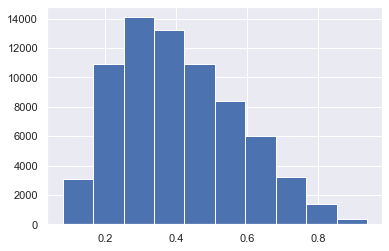

In [55]:
df_topic_sents_keywords.to_csv("bundle_id_topic.csv",index=False)
df_topic_sents_keywords.topic_perc_contrib.hist()

In [56]:
df_topic_sents_keywords[df_topic_sents_keywords.bundle_id.str.contains("grindr|tagged|skout")][[
    "bundle_id", "keywords", "topic_perc_contrib"]]

,bundle_id,keywords,topic_perc_contrib
20747,com.taggedme.fbadvice,"call, sound, chat, message, friend, record, pe...",0.3227
25358,com.taggedapp,"call, sound, chat, message, friend, record, pe...",0.1145
25437,com.skout.android,"call, sound, chat, message, friend, record, pe...",0.2869


### Topic distribution across documents

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['topic_num'].value_counts()
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)


In [ ]:
def get_unique_key_words(group):
    return pd.Series({"keywords":group["keywords"].iloc[0]})

key_words=df_topic_sents_keywords.groupby("topic_num").apply(get_unique_key_words)
key_words.reset_index(inplace=True)

In [ ]:
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)
# Change Column names
df_dominant_topics.columns = ['Num_Documents', 'Perc_Documents']
# Show
df_dominant_topics["topic_num"] = df_dominant_topics.index
df_dominant_topics.reset_index(inplace=True)
df_dominant_topics.drop(["index"], axis=1, inplace=True)
df_dominant_topics = df_dominant_topics.merge(
    key_words, how="inner", on="topic_num")
df_dominant_topics.sort_values("Num_Documents", ascending=False)
df_dominant_topics

In [ ]:
df_dominant_topics.to_csv("df_dominant_topics.csv", index=False)

### Save the model

In [ ]:
help(best_model)

In [ ]:
from datetime import date
date = str(date.today())
best_model.save(f"saved_model/topic_model_{date}")

In [ ]:
loaded_model = gensim.models.wrappers.LdaMallet.load(
    f"saved_model/topic_model_{date}")

In [ ]:
test_df = pd.DataFrame()

# Get main topic in each document
for i, row in enumerate(loaded_model[corpus[:10]]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            wp = loaded_model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            test_df = test_df.append(pd.Series(
                [int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
        else:
            break
test_df.columns = ['Dominant_Topic',
                          'Perc_Contribution', 'Topic_Keywords']
test_df